# ENSEMBLE MODEL

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Libraries" data-toc-modified-id="1-Libraries-1">1 Libraries</a></span></li><li><span><a href="#2-Parameters" data-toc-modified-id="2-Parameters-2">2 Parameters</a></span></li><li><span><a href="#3-Import" data-toc-modified-id="3-Import-3">3 Import</a></span></li><li><span><a href="#4-Functions" data-toc-modified-id="4-Functions-4">4 Functions</a></span></li><li><span><a href="#5-Model-Preparation" data-toc-modified-id="5-Model-Preparation-5">5 Model Preparation</a></span><ul class="toc-item"><li><span><a href="#5.1-Actuals" data-toc-modified-id="5.1-Actuals-5.1">5.1 Actuals</a></span></li><li><span><a href="#5.2-Differences-&amp;-Lags" data-toc-modified-id="5.2-Differences-&amp;-Lags-5.2">5.2 Differences &amp; Lags</a></span></li><li><span><a href="#5.3-Train-&amp;-Test" data-toc-modified-id="5.3-Train-&amp;-Test-5.3">5.3 Train &amp; Test</a></span></li></ul></li><li><span><a href="#6-Model" data-toc-modified-id="6-Model-6">6 Model</a></span></li><li><span><a href="#7-Back-Transformation" data-toc-modified-id="7-Back-Transformation-7">7 Back-Transformation</a></span></li><li><span><a href="#8-Model-Evaluation" data-toc-modified-id="8-Model-Evaluation-8">8 Model Evaluation</a></span></li><li><span><a href="#9-Visualization" data-toc-modified-id="9-Visualization-9">9 Visualization</a></span></li></ul></div>

### 1 Libraries

In [2]:
# Data handling
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Settings
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.6f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import ipywidgets as widgets

# Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from xgboost import XGBRegressor

In [4]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.pyplot import cm
import seaborn as sns

# Date formats
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')
days_fmt = mdates.DateFormatter('%Y-%m-%d')

%config InlineBackend.figure_format ="retina"

### 2 Parameters
***

In [5]:
# Widget for yield curve date frequency
widget_freq = widgets.Dropdown(options=["day","week","month"],
                               value="day",
                               description="Frequency:",
                               disabled=False)

# Widget if absolute yield or yield change shall be predicted
widget_target = widgets.Dropdown(options=["original","delta"],
                                 value="original",
                                 description="Target:",
                                 disabled=False)


display (widget_freq)
display (widget_target)

Dropdown(description='Frequency:', options=('day', 'week', 'month'), value='day')

Dropdown(description='Target:', options=('original', 'delta'), value='original')

In [6]:
freq    = widget_freq.value
target  = widget_target.value

In [7]:
# Prediction
pred_start = "2018-01-01"
steps = 5
lag = 90

### 3 Import
***

In [8]:
# File paths
filepath_spot = "../assets/files/02-clean/"
filepath_pca  = "../assets/files/03-pca/"

# Filenames
filename_T_k  = "T_k_"+str(freq)+".csv"
filename_W_k  = "W_k_inv_"+str(freq)+".csv"
filename_X_k  = "X_k_"+str(freq)+".csv"
filename_spot = "spot_"+str(freq)+".csv"

In [9]:
# Import
W_k_inv = pd.read_csv(filepath_pca + filename_W_k, index_col = 0)   # PC-loadings
T_k     = pd.read_csv(filepath_pca + filename_T_k, index_col = 0)   # PC-scores
X_k     = pd.read_csv(filepath_pca + filename_X_k, index_col = 0)   # Model spot rates
spot    = pd.read_csv(filepath_spot + filename_spot, index_col = 0) # Actual spot rates

# Columns
W_k_inv.columns.name = "W_k_inv_"+str(freq)
T_k.columns.name     = "T_k_"+str(freq)
X_k.columns.name     = "X_k_"+str(freq)
spot.columns.name    = "Spot_"+str(freq)

# Index
T_k.index  = pd.to_datetime(T_k.index)
X_k.index  = pd.to_datetime(X_k.index)
spot.index = pd.to_datetime(spot.index)

In [10]:
# Column names
cols      = W_k_inv.T.columns
cols_diff = cols+"_diff"
cols_cum  = cols+"_cum"
cols_frac = cols+"_frac"
cols_len  = len(cols)

### 4 Functions
***

In [11]:
def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T) 
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    
    return np.real(dx[0:T])

### 5 Model Preparation
***

#### 5.1 Actuals

In [12]:
spot_train = spot[spot.index < pred_start]
spot_test = spot[spot.index >= pred_start]

In [36]:
# Actual yields in train
spot_train.tail()

Spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2017-12-21,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2017-12-22,-0.826033,-0.813788,-0.777337,-0.664987,-0.517400,-0.353124,-0.185911,-0.024712,0.125365,0.261937,0.384398,0.493208,0.674254,0.815247,0.925918,1.014033,1.085353,1.144038,1.193075,1.234619,1.270249,1.301137
2017-12-27,-0.845695,-0.825995,-0.782740,-0.673152,-0.534009,-0.376399,-0.212622,-0.052185,0.098842,0.237252,0.361877,0.472845,0.657611,0.801348,0.913972,1.003493,1.075865,1.135370,1.185069,1.227164,1.263262,1.294552
2017-12-28,-0.748190,-0.746003,-0.726626,-0.637618,-0.502549,-0.344070,-0.178989,-0.018215,0.132025,0.268784,0.391224,0.499750,0.679580,0.818893,0.927803,1.014273,1.084139,1.141569,1.189529,1.230149,1.264981,1.295173
2017-12-29,-0.780057,-0.769592,-0.737874,-0.635217,-0.494164,-0.332811,-0.165891,-0.003460,0.148531,0.287169,0.411562,0.522043,0.705575,0.848121,0.959744,1.048458,1.120177,1.179148,1.228403,1.270123,1.305900,1.336912


In [37]:
# Actual yields in test
spot_test.head()

Spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607,0.425060,0.537615,0.725001,0.870810,0.985105,1.075991,1.149487,1.209929,1.260415,1.303180,1.339852,1.371642
2018-01-03,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841,0.410392,0.521837,0.706840,0.850445,0.962874,1.052225,1.124464,1.183865,1.233482,1.275510,1.311551,1.342792
2018-01-04,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369,0.423126,0.532726,0.714207,0.854750,0.964630,1.051888,1.122404,1.180376,1.228794,1.269804,1.304971,1.335455
2018-01-05,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587,0.413031,0.523487,0.706836,0.849153,0.960575,1.049129,1.120726,1.179601,1.228778,1.270434,1.306157,1.337122
2018-01-08,-0.646781,-0.664524,-0.675209,-0.620244,-0.499954,-0.346989,-0.182959,-0.021089,0.131257,0.270563,0.395694,0.506896,0.691724,0.835372,0.947927,1.037427,1.109810,1.169342,1.219072,1.261199,1.297326,1.328643


#### 5.2 Differences & Lags

In [15]:
# Add lags to absolute components ---------------------------------------------------------
if target == "original":
    for i in cols:
        for j in range(steps, steps + lag + 1):
            T_k[i+"_lag_"+str(j)] = T_k[i].shift(j)  
        

if target == "delta":
    # Add differences to delta components -------------------------------------------------
    for i in cols:
        T_k[i+"_diff"] = T_k[i].diff()
        
    for i in cols:
        T_k[i+"_frac"] = fast_fracdiff(x = T_k[i], d=0.35)

    # Add lags to delta components --------------------------------------------------------        
    for i in cols_diff:
        for j in range(steps, steps + lag + 1):
            T_k[i+"_lag_"+str(j)] = T_k[i].shift(j)
            
    for i in cols_frac:
        for j in range(steps, steps + lag + 1):
            T_k[i+"_lag_"+str(j)] = T_k[i].shift(j)
            
    for i in cols:
        T_k = T_k.drop(i, axis = 1)


# Print -----------------------------------------------------------------------------------
T_k = T_k.iloc[steps + lag + 1:]
T_k.tail(5)

T_k_day,PC_1,PC_2,PC_3,PC_1_lag_5,PC_1_lag_6,PC_1_lag_7,PC_1_lag_8,PC_1_lag_9,PC_1_lag_10,PC_1_lag_11,PC_1_lag_12,PC_1_lag_13,PC_1_lag_14,PC_1_lag_15,PC_1_lag_16,PC_1_lag_17,PC_1_lag_18,PC_1_lag_19,PC_1_lag_20,PC_1_lag_21,PC_1_lag_22,PC_1_lag_23,PC_1_lag_24,PC_1_lag_25,PC_1_lag_26,PC_1_lag_27,PC_1_lag_28,PC_1_lag_29,PC_1_lag_30,PC_1_lag_31,PC_1_lag_32,PC_1_lag_33,PC_1_lag_34,PC_1_lag_35,PC_1_lag_36,PC_1_lag_37,PC_1_lag_38,PC_1_lag_39,PC_1_lag_40,PC_1_lag_41,PC_1_lag_42,PC_1_lag_43,PC_1_lag_44,PC_1_lag_45,PC_1_lag_46,PC_1_lag_47,PC_1_lag_48,PC_1_lag_49,PC_1_lag_50,PC_1_lag_51,PC_1_lag_52,PC_1_lag_53,PC_1_lag_54,PC_1_lag_55,PC_1_lag_56,PC_1_lag_57,PC_1_lag_58,PC_1_lag_59,PC_1_lag_60,PC_1_lag_61,PC_1_lag_62,PC_1_lag_63,PC_1_lag_64,PC_1_lag_65,PC_1_lag_66,PC_1_lag_67,PC_1_lag_68,PC_1_lag_69,PC_1_lag_70,PC_1_lag_71,PC_1_lag_72,PC_1_lag_73,PC_1_lag_74,PC_1_lag_75,PC_1_lag_76,PC_1_lag_77,PC_1_lag_78,PC_1_lag_79,PC_1_lag_80,PC_1_lag_81,PC_1_lag_82,PC_1_lag_83,PC_1_lag_84,PC_1_lag_85,PC_1_lag_86,PC_1_lag_87,PC_1_lag_88,PC_1_lag_89,PC_1_lag_90,PC_1_lag_91,PC_1_lag_92,PC_1_lag_93,PC_1_lag_94,PC_1_lag_95,PC_2_lag_5,PC_2_lag_6,PC_2_lag_7,PC_2_lag_8,PC_2_lag_9,PC_2_lag_10,PC_2_lag_11,PC_2_lag_12,PC_2_lag_13,PC_2_lag_14,PC_2_lag_15,PC_2_lag_16,PC_2_lag_17,PC_2_lag_18,PC_2_lag_19,PC_2_lag_20,PC_2_lag_21,PC_2_lag_22,PC_2_lag_23,PC_2_lag_24,PC_2_lag_25,PC_2_lag_26,PC_2_lag_27,PC_2_lag_28,PC_2_lag_29,PC_2_lag_30,PC_2_lag_31,PC_2_lag_32,PC_2_lag_33,PC_2_lag_34,PC_2_lag_35,PC_2_lag_36,PC_2_lag_37,PC_2_lag_38,PC_2_lag_39,PC_2_lag_40,PC_2_lag_41,PC_2_lag_42,PC_2_lag_43,PC_2_lag_44,PC_2_lag_45,PC_2_lag_46,PC_2_lag_47,PC_2_lag_48,PC_2_lag_49,PC_2_lag_50,PC_2_lag_51,PC_2_lag_52,PC_2_lag_53,PC_2_lag_54,PC_2_lag_55,PC_2_lag_56,PC_2_lag_57,PC_2_lag_58,PC_2_lag_59,PC_2_lag_60,PC_2_lag_61,PC_2_lag_62,PC_2_lag_63,PC_2_lag_64,PC_2_lag_65,PC_2_lag_66,PC_2_lag_67,PC_2_lag_68,PC_2_lag_69,PC_2_lag_70,PC_2_lag_71,PC_2_lag_72,PC_2_lag_73,PC_2_lag_74,PC_2_lag_75,PC_2_lag_76,PC_2_lag_77,PC_2_lag_78,PC_2_lag_79,PC_2_lag_80,PC_2_lag_81,PC_2_lag_82,PC_2_lag_83,PC_2_lag_84,PC_2_lag_85,PC_2_lag_86,PC_2_lag_87,PC_2_lag_88,PC_2_lag_89,PC_2_lag_90,PC_2_lag_91,PC_2_lag_92,PC_2_lag_93,PC_2_lag_94,PC_2_lag_95,PC_3_lag_5,PC_3_lag_6,PC_3_lag_7,PC_3_lag_8,PC_3_lag_9,PC_3_lag_10,PC_3_lag_11,PC_3_lag_12,PC_3_lag_13,PC_3_lag_14,PC_3_lag_15,PC_3_lag_16,PC_3_lag_17,PC_3_lag_18,PC_3_lag_19,PC_3_lag_20,PC_3_lag_21,PC_3_lag_22,PC_3_lag_23,PC_3_lag_24,PC_3_lag_25,PC_3_lag_26,PC_3_lag_27,PC_3_lag_28,PC_3_lag_29,PC_3_lag_30,PC_3_lag_31,PC_3_lag_32,PC_3_lag_33,PC_3_lag_34,PC_3_lag_35,PC_3_lag_36,PC_3_lag_37,PC_3_lag_38,PC_3_lag_39,PC_3_lag_40,PC_3_lag_41,PC_3_lag_42,PC_3_lag_43,PC_3_lag_44,PC_3_lag_45,PC_3_lag_46,PC_3_lag_47,PC_3_lag_48,PC_3_lag_49,PC_3_lag_50,PC_3_lag_51,PC_3_lag_52,PC_3_lag_53,PC_3_lag_54,PC_3_lag_55,PC_3_lag_56,PC_3_lag_57,PC_3_lag_58,PC_3_lag_59,PC_3_lag_60,PC_3_lag_61,PC_3_lag_62,PC_3_lag_63,PC_3_lag_64,PC_3_lag_65,PC_3_lag_66,PC_3_lag_67,PC_3_lag_68,PC_3_lag_69,PC_3_lag_70,PC_3_lag_71,PC_3_lag_72,PC_3_lag_73,PC_3_lag_74,PC_3_lag_75,PC_3_lag_76,PC_3_lag_77,PC_3_lag_78,PC_3_lag_79,PC_3_lag_80,PC_3_lag_81,PC_3_lag_82,PC_3_lag_83,PC_3_lag_84,PC_3_lag_85,PC_3_lag_86,PC_3_lag_87,PC_3_lag_88,PC_3_lag_89,PC_3_lag_90,PC_3_lag_91,PC_3_lag_92,PC_3_lag_93,PC_3_lag_94,PC_3_lag_95
2019-12-19,0.859157,-1.556938,-0.579007,1.092020,1.169228,1.103503,1.145479,1.108150,1.069976,1.267522,1.250405,1.036445,1.280493,1.337484,1.344298,1.383379,1.323045,1.282774,1.211272,1.347706,1.248941,1.270042,1.275368,1.268594,1.130374,0.925113,0.962969,0.956871,0.994600,1.196772,1.179878,1.311792,1.484055,1.570696,1.334792,1.311670,1.231164,1.433568,1.531588,1.517523,1.409456,1.285576,1.418699,1.492701,1.439670,1.743698,1.733878,1.711662,1.850447,2.187248,2.303366,2.260077,2.297556,2.324719,2.123575,2.110726,2.242589,2.330770,2.301954,2.389038,2.295908,2.265414,2.004355,1.937724,1.930670,1.819480,1.797225,1.829289,2.247440,2.208008,2.232434,2.258774,2.521197,2.343570,2.652245,2.823196,2.795844,2.858371,2

#### 5.3 Train & Test

In [16]:
train = T_k[T_k.index < pred_start]

if target == "original":
    X_train = train.iloc[:,cols_len*1:]
    
else:
    X_train = train.iloc[:,cols_len*2:]

X_train_val = X_train.values

In [17]:
X_train.tail()

T_k_day,PC_1_lag_5,PC_1_lag_6,PC_1_lag_7,PC_1_lag_8,PC_1_lag_9,PC_1_lag_10,PC_1_lag_11,PC_1_lag_12,PC_1_lag_13,PC_1_lag_14,PC_1_lag_15,PC_1_lag_16,PC_1_lag_17,PC_1_lag_18,PC_1_lag_19,PC_1_lag_20,PC_1_lag_21,PC_1_lag_22,PC_1_lag_23,PC_1_lag_24,PC_1_lag_25,PC_1_lag_26,PC_1_lag_27,PC_1_lag_28,PC_1_lag_29,PC_1_lag_30,PC_1_lag_31,PC_1_lag_32,PC_1_lag_33,PC_1_lag_34,PC_1_lag_35,PC_1_lag_36,PC_1_lag_37,PC_1_lag_38,PC_1_lag_39,PC_1_lag_40,PC_1_lag_41,PC_1_lag_42,PC_1_lag_43,PC_1_lag_44,PC_1_lag_45,PC_1_lag_46,PC_1_lag_47,PC_1_lag_48,PC_1_lag_49,PC_1_lag_50,PC_1_lag_51,PC_1_lag_52,PC_1_lag_53,PC_1_lag_54,PC_1_lag_55,PC_1_lag_56,PC_1_lag_57,PC_1_lag_58,PC_1_lag_59,PC_1_lag_60,PC_1_lag_61,PC_1_lag_62,PC_1_lag_63,PC_1_lag_64,PC_1_lag_65,PC_1_lag_66,PC_1_lag_67,PC_1_lag_68,PC_1_lag_69,PC_1_lag_70,PC_1_lag_71,PC_1_lag_72,PC_1_lag_73,PC_1_lag_74,PC_1_lag_75,PC_1_lag_76,PC_1_lag_77,PC_1_lag_78,PC_1_lag_79,PC_1_lag_80,PC_1_lag_81,PC_1_lag_82,PC_1_lag_83,PC_1_lag_84,PC_1_lag_85,PC_1_lag_86,PC_1_lag_87,PC_1_lag_88,PC_1_lag_89,PC_1_lag_90,PC_1_lag_91,PC_1_lag_92,PC_1_lag_93,PC_1_lag_94,PC_1_lag_95,PC_2_lag_5,PC_2_lag_6,PC_2_lag_7,PC_2_lag_8,PC_2_lag_9,PC_2_lag_10,PC_2_lag_11,PC_2_lag_12,PC_2_lag_13,PC_2_lag_14,PC_2_lag_15,PC_2_lag_16,PC_2_lag_17,PC_2_lag_18,PC_2_lag_19,PC_2_lag_20,PC_2_lag_21,PC_2_lag_22,PC_2_lag_23,PC_2_lag_24,PC_2_lag_25,PC_2_lag_26,PC_2_lag_27,PC_2_lag_28,PC_2_lag_29,PC_2_lag_30,PC_2_lag_31,PC_2_lag_32,PC_2_lag_33,PC_2_lag_34,PC_2_lag_35,PC_2_lag_36,PC_2_lag_37,PC_2_lag_38,PC_2_lag_39,PC_2_lag_40,PC_2_lag_41,PC_2_lag_42,PC_2_lag_43,PC_2_lag_44,PC_2_lag_45,PC_2_lag_46,PC_2_lag_47,PC_2_lag_48,PC_2_lag_49,PC_2_lag_50,PC_2_lag_51,PC_2_lag_52,PC_2_lag_53,PC_2_lag_54,PC_2_lag_55,PC_2_lag_56,PC_2_lag_57,PC_2_lag_58,PC_2_lag_59,PC_2_lag_60,PC_2_lag_61,PC_2_lag_62,PC_2_lag_63,PC_2_lag_64,PC_2_lag_65,PC_2_lag_66,PC_2_lag_67,PC_2_lag_68,PC_2_lag_69,PC_2_lag_70,PC_2_lag_71,PC_2_lag_72,PC_2_lag_73,PC_2_lag_74,PC_2_lag_75,PC_2_lag_76,PC_2_lag_77,PC_2_lag_78,PC_2_lag_79,PC_2_lag_80,PC_2_lag_81,PC_2_lag_82,PC_2_lag_83,PC_2_lag_84,PC_2_lag_85,PC_2_lag_86,PC_2_lag_87,PC_2_lag_88,PC_2_lag_89,PC_2_lag_90,PC_2_lag_91,PC_2_lag_92,PC_2_lag_93,PC_2_lag_94,PC_2_lag_95,PC_3_lag_5,PC_3_lag_6,PC_3_lag_7,PC_3_lag_8,PC_3_lag_9,PC_3_lag_10,PC_3_lag_11,PC_3_lag_12,PC_3_lag_13,PC_3_lag_14,PC_3_lag_15,PC_3_lag_16,PC_3_lag_17,PC_3_lag_18,PC_3_lag_19,PC_3_lag_20,PC_3_lag_21,PC_3_lag_22,PC_3_lag_23,PC_3_lag_24,PC_3_lag_25,PC_3_lag_26,PC_3_lag_27,PC_3_lag_28,PC_3_lag_29,PC_3_lag_30,PC_3_lag_31,PC_3_lag_32,PC_3_lag_33,PC_3_lag_34,PC_3_lag_35,PC_3_lag_36,PC_3_lag_37,PC_3_lag_38,PC_3_lag_39,PC_3_lag_40,PC_3_lag_41,PC_3_lag_42,PC_3_lag_43,PC_3_lag_44,PC_3_lag_45,PC_3_lag_46,PC_3_lag_47,PC_3_lag_48,PC_3_lag_49,PC_3_lag_50,PC_3_lag_51,PC_3_lag_52,PC_3_lag_53,PC_3_lag_54,PC_3_lag_55,PC_3_lag_56,PC_3_lag_57,PC_3_lag_58,PC_3_lag_59,PC_3_lag_60,PC_3_lag_61,PC_3_lag_62,PC_3_lag_63,PC_3_lag_64,PC_3_lag_65,PC_3_lag_66,PC_3_lag_67,PC_3_lag_68,PC_3_lag_69,PC_3_lag_70,PC_3_lag_71,PC_3_lag_72,PC_3_lag_73,PC_3_lag_74,PC_3_lag_75,PC_3_lag_76,PC_3_lag_77,PC_3_lag_78,PC_3_lag_79,PC_3_lag_80,PC_3_lag_81,PC_3_lag_82,PC_3_lag_83,PC_3_lag_84,PC_3_lag_85,PC_3_lag_86,PC_3_lag_87,PC_3_lag_88,PC_3_lag_89,PC_3_lag_90,PC_3_lag_91,PC_3_lag_92,PC_3_lag_93,PC_3_lag_94,PC_3_lag_95
2017-12-21,-1.232593,-1.184641,-1.154927,-1.092986,-1.127482,-1.077642,-1.061021,-1.226693,-1.256623,-1.264558,-1.391449,-1.471750,-1.307421,-1.319552,-1.361287,-1.312984,-1.353990,-1.322787,-1.401607,-1.452290,-1.463398,-1.392895,-1.595094,-1.579111,-1.514882,-1.427265,-1.216969,-1.308448,-1.307335,-1.347642,-1.462268,-1.424694,-1.431308,-1.445558,-1.579527,-1.666949,-1.823230,-1.752354,-1.588129,-1.674660,-1.437010,-1.435534,-1.358267,-1.416754,-1.515557,-1.651032,-1.688740,-1.654825,-1.659860,-1.858364,-1.648585,-1.599187,-1.691671,-1.610679,-1.711245,-1.755383,-1.720960,-1.498765,-1.564746,-1.626066,-1.638114,-1.587089,-1.629516,-1.688316,-1.595637,-1.512821,-1.489200,-1.355334,-1.182561,-1.132625,-1.109644,-1.181849,

In [18]:
X_test = pd.DataFrame(data = np.zeros([steps,X_train.shape[1]]),
                      columns = X_train.columns,
                      index = spot_test.index[:steps])

test_cols = X_test.columns
test_lag  = X_test.columns.str.split("_", expand = True).to_frame().iloc[:,-1].values
test_pc   = X_test.columns.str.split("_", expand = True).to_frame().iloc[:,1].values
rows      = T_k.shape[0]

if target == "original":
    for i,j,k in zip (test_cols, test_pc, test_lag):
        X_test[i] = T_k["PC_"+str(j)].iloc[rows-int(k):rows-int(k)+steps].values
else:
    for i,j,k in zip (test_cols, test_pc, test_lag):
        X_test[i] = T_k["PC_"+j+"_diff"].iloc[rows-int(k):rows-int(k)+steps].values
    
X_test

T_k_day,PC_1_lag_5,PC_1_lag_6,PC_1_lag_7,PC_1_lag_8,PC_1_lag_9,PC_1_lag_10,PC_1_lag_11,PC_1_lag_12,PC_1_lag_13,PC_1_lag_14,PC_1_lag_15,PC_1_lag_16,PC_1_lag_17,PC_1_lag_18,PC_1_lag_19,PC_1_lag_20,PC_1_lag_21,PC_1_lag_22,PC_1_lag_23,PC_1_lag_24,PC_1_lag_25,PC_1_lag_26,PC_1_lag_27,PC_1_lag_28,PC_1_lag_29,PC_1_lag_30,PC_1_lag_31,PC_1_lag_32,PC_1_lag_33,PC_1_lag_34,PC_1_lag_35,PC_1_lag_36,PC_1_lag_37,PC_1_lag_38,PC_1_lag_39,PC_1_lag_40,PC_1_lag_41,PC_1_lag_42,PC_1_lag_43,PC_1_lag_44,PC_1_lag_45,PC_1_lag_46,PC_1_lag_47,PC_1_lag_48,PC_1_lag_49,PC_1_lag_50,PC_1_lag_51,PC_1_lag_52,PC_1_lag_53,PC_1_lag_54,PC_1_lag_55,PC_1_lag_56,PC_1_lag_57,PC_1_lag_58,PC_1_lag_59,PC_1_lag_60,PC_1_lag_61,PC_1_lag_62,PC_1_lag_63,PC_1_lag_64,PC_1_lag_65,PC_1_lag_66,PC_1_lag_67,PC_1_lag_68,PC_1_lag_69,PC_1_lag_70,PC_1_lag_71,PC_1_lag_72,PC_1_lag_73,PC_1_lag_74,PC_1_lag_75,PC_1_lag_76,PC_1_lag_77,PC_1_lag_78,PC_1_lag_79,PC_1_lag_80,PC_1_lag_81,PC_1_lag_82,PC_1_lag_83,PC_1_lag_84,PC_1_lag_85,PC_1_lag_86,PC_1_lag_87,PC_1_lag_88,PC_1_lag_89,PC_1_lag_90,PC_1_lag_91,PC_1_lag_92,PC_1_lag_93,PC_1_lag_94,PC_1_lag_95,PC_2_lag_5,PC_2_lag_6,PC_2_lag_7,PC_2_lag_8,PC_2_lag_9,PC_2_lag_10,PC_2_lag_11,PC_2_lag_12,PC_2_lag_13,PC_2_lag_14,PC_2_lag_15,PC_2_lag_16,PC_2_lag_17,PC_2_lag_18,PC_2_lag_19,PC_2_lag_20,PC_2_lag_21,PC_2_lag_22,PC_2_lag_23,PC_2_lag_24,PC_2_lag_25,PC_2_lag_26,PC_2_lag_27,PC_2_lag_28,PC_2_lag_29,PC_2_lag_30,PC_2_lag_31,PC_2_lag_32,PC_2_lag_33,PC_2_lag_34,PC_2_lag_35,PC_2_lag_36,PC_2_lag_37,PC_2_lag_38,PC_2_lag_39,PC_2_lag_40,PC_2_lag_41,PC_2_lag_42,PC_2_lag_43,PC_2_lag_44,PC_2_lag_45,PC_2_lag_46,PC_2_lag_47,PC_2_lag_48,PC_2_lag_49,PC_2_lag_50,PC_2_lag_51,PC_2_lag_52,PC_2_lag_53,PC_2_lag_54,PC_2_lag_55,PC_2_lag_56,PC_2_lag_57,PC_2_lag_58,PC_2_lag_59,PC_2_lag_60,PC_2_lag_61,PC_2_lag_62,PC_2_lag_63,PC_2_lag_64,PC_2_lag_65,PC_2_lag_66,PC_2_lag_67,PC_2_lag_68,PC_2_lag_69,PC_2_lag_70,PC_2_lag_71,PC_2_lag_72,PC_2_lag_73,PC_2_lag_74,PC_2_lag_75,PC_2_lag_76,PC_2_lag_77,PC_2_lag_78,PC_2_lag_79,PC_2_lag_80,PC_2_lag_81,PC_2_lag_82,PC_2_lag_83,PC_2_lag_84,PC_2_lag_85,PC_2_lag_86,PC_2_lag_87,PC_2_lag_88,PC_2_lag_89,PC_2_lag_90,PC_2_lag_91,PC_2_lag_92,PC_2_lag_93,PC_2_lag_94,PC_2_lag_95,PC_3_lag_5,PC_3_lag_6,PC_3_lag_7,PC_3_lag_8,PC_3_lag_9,PC_3_lag_10,PC_3_lag_11,PC_3_lag_12,PC_3_lag_13,PC_3_lag_14,PC_3_lag_15,PC_3_lag_16,PC_3_lag_17,PC_3_lag_18,PC_3_lag_19,PC_3_lag_20,PC_3_lag_21,PC_3_lag_22,PC_3_lag_23,PC_3_lag_24,PC_3_lag_25,PC_3_lag_26,PC_3_lag_27,PC_3_lag_28,PC_3_lag_29,PC_3_lag_30,PC_3_lag_31,PC_3_lag_32,PC_3_lag_33,PC_3_lag_34,PC_3_lag_35,PC_3_lag_36,PC_3_lag_37,PC_3_lag_38,PC_3_lag_39,PC_3_lag_40,PC_3_lag_41,PC_3_lag_42,PC_3_lag_43,PC_3_lag_44,PC_3_lag_45,PC_3_lag_46,PC_3_lag_47,PC_3_lag_48,PC_3_lag_49,PC_3_lag_50,PC_3_lag_51,PC_3_lag_52,PC_3_lag_53,PC_3_lag_54,PC_3_lag_55,PC_3_lag_56,PC_3_lag_57,PC_3_lag_58,PC_3_lag_59,PC_3_lag_60,PC_3_lag_61,PC_3_lag_62,PC_3_lag_63,PC_3_lag_64,PC_3_lag_65,PC_3_lag_66,PC_3_lag_67,PC_3_lag_68,PC_3_lag_69,PC_3_lag_70,PC_3_lag_71,PC_3_lag_72,PC_3_lag_73,PC_3_lag_74,PC_3_lag_75,PC_3_lag_76,PC_3_lag_77,PC_3_lag_78,PC_3_lag_79,PC_3_lag_80,PC_3_lag_81,PC_3_lag_82,PC_3_lag_83,PC_3_lag_84,PC_3_lag_85,PC_3_lag_86,PC_3_lag_87,PC_3_lag_88,PC_3_lag_89,PC_3_lag_90,PC_3_lag_91,PC_3_lag_92,PC_3_lag_93,PC_3_lag_94,PC_3_lag_95
2018-01-02,0.859157,0.991183,1.103654,1.111428,1.026352,1.092020,1.169228,1.103503,1.145479,1.108150,1.069976,1.267522,1.250405,1.036445,1.280493,1.337484,1.344298,1.383379,1.323045,1.282774,1.211272,1.347706,1.248941,1.270042,1.275368,1.268594,1.130374,0.925113,0.962969,0.956871,0.994600,1.196772,1.179878,1.311792,1.484055,1.570696,1.334792,1.311670,1.231164,1.433568,1.531588,1.517523,1.409456,1.285576,1.418699,1.492701,1.439670,1.743698,1.733878,1.711662,1.850447,2.187248,2.303366,2.260077,2.297556,2.324719,2.123575,2.110726,2.242589,2.330770,2.301954,2.389038,2.295908,2.265414,2.004355,1.937724,1.930670,1.819480,1.797225,1.829289,2.247440,2.208008,2.232434,2.258774,2.521197,2.343570,2.652245,2.823196,2.795844,2.858371,

In [19]:
X_train["month"]   = X_train.index.month
X_train["weekday"] = X_train.index.weekday
X_train["day"]     = X_train.index.weekday
X_train["year"]    = X_train.index.year

X_test["month"]    = X_test.index.month
X_test["weekday"]  = X_test.index.weekday
X_test["day"]      = X_test.index.weekday
X_test["year"]     = X_test.index.year

In [20]:
last_train = train.iloc[-1,:len(cols)]
last_train

T_k_day
PC_1   -1.739679
PC_2   -3.328044
PC_3   -1.012013
Name: 2017-12-29 00:00:00, dtype: float64

### 6 Model
***

In [21]:
rand_forest = RandomForestRegressor(n_estimators = 400, max_features = 5, random_state = 1)
xgb         = XGBRegressor(verbosity = 0, num_feature = 5)

In [22]:
loop = cols if target == "original" else cols_diff

pred_scores = pd.DataFrame(data = np.zeros([steps,cols_len]), index = X_test.index[:steps], columns = loop)
pred_scores.columns.name = "pred_scores_" + str(freq)

for i in loop:

    Y_train = train[i]
    Y_train = Y_train.values.ravel()
    
    model = xgb

    X_cols = [col for col in X_train if col.startswith(i[:4])]
    X_cols.append("day")
    X_cols.append("weekday")
    X_cols.append("month")
    X_cols.append("year")
    
    model.fit(X_train[X_cols], Y_train)
    
    
    feat_importance = pd.DataFrame(data = model.feature_importances_, 
                                   index = X_cols, 
                                   columns = [str(i)]) \
                        .sort_values(by = str(i), ascending = False) \
                        .reset_index(drop = False) \
                        .iloc[:10]

    Y_pred = model.predict(X_test[X_cols])
    Y_pred = pd.Series(Y_pred, index = spot_test.index[:steps])
    pred_scores[i] = Y_pred
    
    print (feat_importance)
    print (feat_importance.iloc[:,1].sum())

         index     PC_1
0  PC_1_lag_20 0.211266
1  PC_1_lag_21 0.149952
2  PC_1_lag_63 0.107992
3   PC_1_lag_5 0.093104
4  PC_1_lag_78 0.080881
5   PC_1_lag_8 0.060838
6         year 0.058478
7  PC_1_lag_84 0.054535
8  PC_1_lag_61 0.028064
9  PC_1_lag_52 0.024539
0.86964905
         index     PC_2
0   PC_2_lag_5 0.610444
1   PC_2_lag_7 0.087727
2   PC_2_lag_9 0.055670
3  PC_2_lag_26 0.045039
4   PC_2_lag_6 0.030076
5   PC_2_lag_8 0.016004
6  PC_2_lag_27 0.015108
7  PC_2_lag_14 0.013863
8  PC_2_lag_30 0.009888
9  PC_2_lag_11 0.009446
0.8932635
         index     PC_3
0   PC_3_lag_5 0.439786
1  PC_3_lag_17 0.056430
2   PC_3_lag_7 0.024604
3   PC_3_lag_9 0.016687
4  PC_3_lag_82 0.016429
5   PC_3_lag_6 0.016047
6  PC_3_lag_16 0.014101
7  PC_3_lag_57 0.012742
8  PC_3_lag_53 0.011991
9   PC_3_lag_8 0.011560
0.6203787


In [23]:
# Predicted PC scores
pred_scores

pred_scores_day,PC_1,PC_2,PC_3
2018-01-02,0.280247,-1.742875,-0.617851
2018-01-03,0.280247,-1.742875,-0.639737
2018-01-04,0.280247,-1.742875,-0.619022
2018-01-05,0.280247,-1.742875,-0.621976
2018-01-08,0.280247,-1.788706,-0.618097


### 7 Back-Transformation
***

In [24]:
pred_spot = np.matrix(pred_scores) * np.matrix(W_k_inv)
pred_spot = pd.DataFrame(data = pred_spot,
                         columns = W_k_inv.columns,
                         index = X_test.index[:steps])

if target == "delta":
    pred_spot = pred_spot.cumsum()
    pred_spot = pred_spot + np.array(spot_train.iloc[-1:,:])

pred_spot.columns.name = "pred_spot_" + str(freq)

In [25]:
# Predicted spot rates
pred_spot

pred_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.502604,-0.570890,-0.651722,-0.673905,-0.610015,-0.512753,-0.403926,-0.294150,-0.189127,-0.092001,-0.004413,0.072943,0.197056,0.283708,0.338902,0.369149,0.380453,0.377916,0.365652,0.346858,0.323948,0.298701
2018-01-03,-0.493616,-0.563689,-0.648518,-0.676380,-0.615371,-0.519306,-0.410662,-0.300457,-0.194647,-0.096547,-0.007912,0.070491,0.196523,0.284733,0.341094,0.372153,0.383979,0.381740,0.369610,0.350838,0.327876,0.302531
2018-01-04,-0.502123,-0.570505,-0.651550,-0.674037,-0.610302,-0.513103,-0.404286,-0.294488,-0.189422,-0.092244,-0.004600,0.072811,0.197027,0.283762,0.339020,0.369310,0.380642,0.378121,0.365864,0.347071,0.324158,0.298906
2018-01-05,-0.500910,-0.569533,-0.651118,-0.674371,-0.611025,-0.513988,-0.405196,-0.295339,-0.190167,-0.092858,-0.005072,0.072480,0.196955,0.283901,0.339316,0.369715,0.381118,0.378637,0.366398,0.347608,0.324689,0.299423
2018-01-08,-0.520944,-0.589681,-0.669660,-0.688203,-0.620489,-0.519776,-0.407950,-0.295607,-0.188407,-0.089451,-0.000339,0.078272,0.204221,0.291990,0.347765,0.378197,0.389403,0.386568,0.373872,0.354558,0.331075,0.305227


In [26]:
# Actual spot rates
spot_test.iloc[:steps]

Spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607,0.425060,0.537615,0.725001,0.870810,0.985105,1.075991,1.149487,1.209929,1.260415,1.303180,1.339852,1.371642
2018-01-03,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841,0.410392,0.521837,0.706840,0.850445,0.962874,1.052225,1.124464,1.183865,1.233482,1.275510,1.311551,1.342792
2018-01-04,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369,0.423126,0.532726,0.714207,0.854750,0.964630,1.051888,1.122404,1.180376,1.228794,1.269804,1.304971,1.335455
2018-01-05,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587,0.413031,0.523487,0.706836,0.849153,0.960575,1.049129,1.120726,1.179601,1.228778,1.270434,1.306157,1.337122
2018-01-08,-0.646781,-0.664524,-0.675209,-0.620244,-0.499954,-0.346989,-0.182959,-0.021089,0.131257,0.270563,0.395694,0.506896,0.691724,0.835372,0.947927,1.037427,1.109810,1.169342,1.219072,1.261199,1.297326,1.328643


In [27]:
naive = pd.DataFrame(spot_train.iloc[-steps,:]).T
naive = pd.concat([naive]*steps, ignore_index=True)
naive.index = spot_test.index[:steps]

naive.columns.name = "naive_spot_" + str(freq)
naive

naive_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-03,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-04,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-05,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-08,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604


### 8 Model Evaluation
***

In [28]:
# Prediction Error to Actual Yields
error_act = pred_spot - spot_test.iloc[:steps,:]
error_act.index = error_act.index.date
error_act

pred_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,0.243395,0.167554,0.060506,-0.055456,-0.126966,-0.188209,-0.245532,-0.298799,-0.347212,-0.390607,-0.429473,-0.464673,-0.527945,-0.587103,-0.646202,-0.706842,-0.769034,-0.832012,-0.894763,-0.956322,-1.015904,-1.072941
2018-01-03,0.196110,0.135501,0.048411,-0.050531,-0.118472,-0.180232,-0.238471,-0.291875,-0.339499,-0.381388,-0.418303,-0.451347,-0.510317,-0.565712,-0.621780,-0.680073,-0.740485,-0.802126,-0.863872,-0.924672,-0.983675,-1.040262
2018-01-04,0.162588,0.106585,0.026825,-0.064829,-0.130654,-0.192005,-0.250140,-0.303285,-0.350412,-0.391613,-0.427726,-0.459915,-0.517179,-0.570988,-0.625610,-0.682578,-0.741762,-0.802255,-0.862930,-0.922733,-0.980812,-1.036549
2018-01-05,0.158559,0.102801,0.024148,-0.063905,-0.126032,-0.184536,-0.240858,-0.293094,-0.339996,-0.381445,-0.418103,-0.451007,-0.509880,-0.565252,-0.621260,-0.679414,-0.739608,-0.800964,-0.862380,-0.922826,-0.981468,-1.037700
2018-01-08,0.125837,0.074842,0.005549,-0.067959,-0.120535,-0.172787,-0.224991,-0.274518,-0.319665,-0.360015,-0.396034,-0.428623,-0.487503,-0.543382,-0.600162,-0.659231,-0.720408,-0.782773,-0.845201,-0.906641,-0.966250,-1.023416


In [29]:
error_naive = naive - spot_test.iloc[:steps,:]
error_naive.index = error_naive.index.date

In [30]:
mae_act    = pd.Series([abs(error_act.iloc[i,:]).mean() for i in range(steps)])
mae_naive  = pd.Series([abs(error_naive.iloc[i,:]).mean() for i in range(steps)])

err = pd.concat([mae_act, mae_naive], axis = 1)
err.columns = ["mae_act", "mae_naive"]
err.index = pred_spot.index

display (err)
display (err.mean())

,mae_act,mae_naive
2018-01-02,0.501248,0.043531
2018-01-03,0.481051,0.031859
2018-01-04,0.482272,0.040517
2018-01-05,0.477511,0.036738
2018-01-08,0.459378,0.026012


mae_act     0.480292
mae_naive   0.035731
dtype: float64

In [31]:
file_object = open("../assets/files/04-results/ensemble.txt", "a")
file_object.write(str(err))
file_object.close()

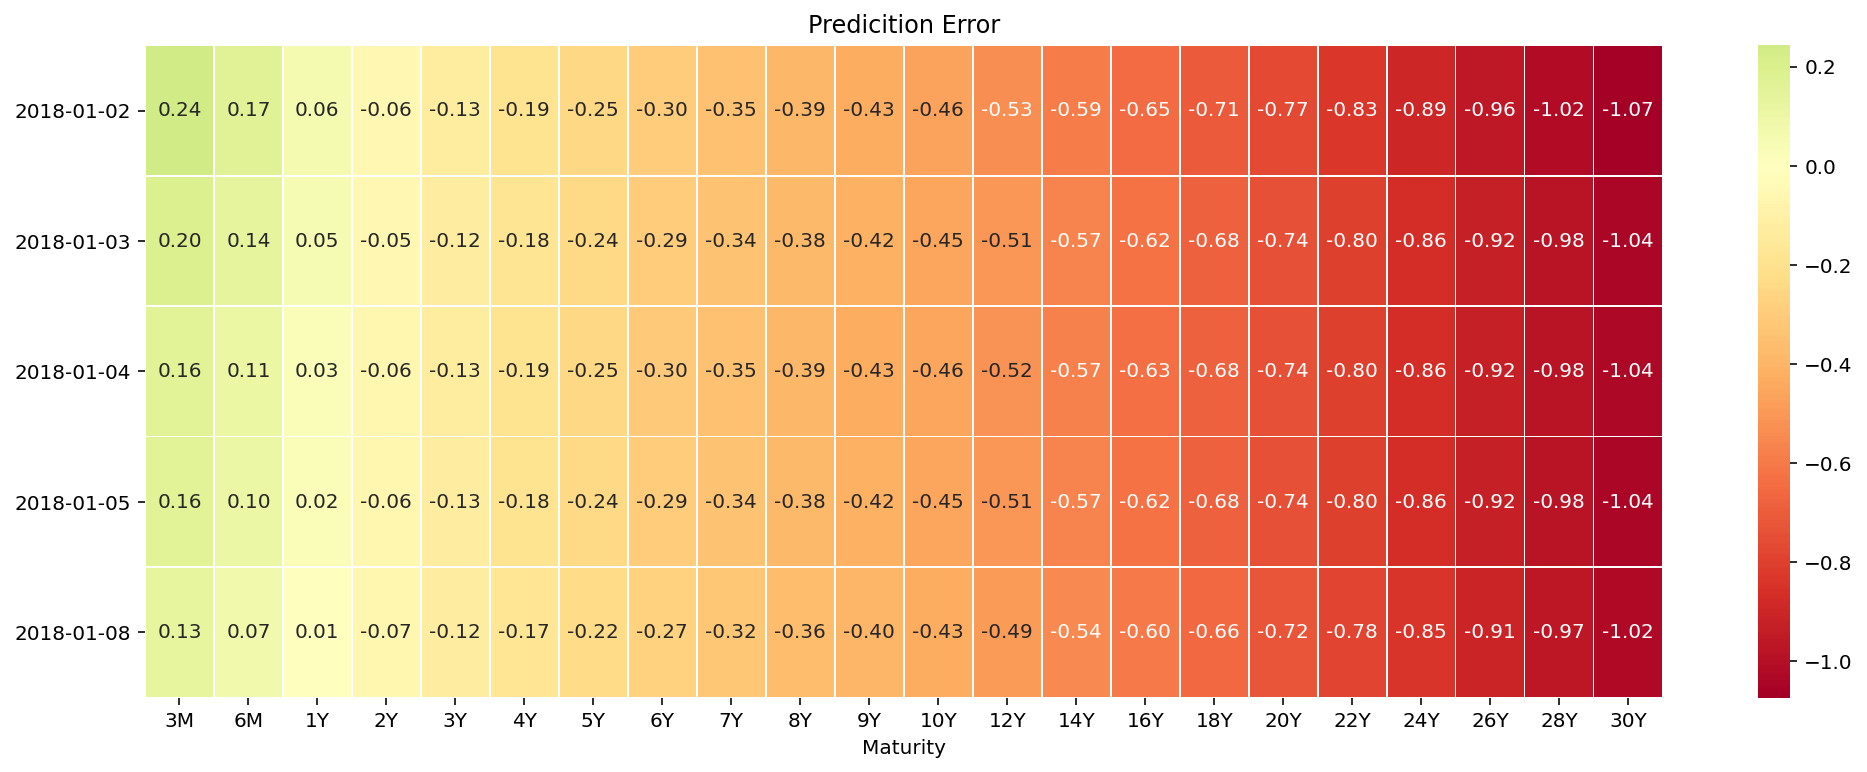

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (17,6))

plt.title("Predicition Error", fontsize = 12)
ttl = ax.title
ttl.set_position([0.5,1.02])

sns.heatmap(error_act, 
            fmt=".2f", 
            cmap = "RdYlGn", 
            linewidth = 0.3, 
            annot = True,
            center = 0)

plt.yticks(rotation=0)
plt.xlabel("Maturity")
plt.show()

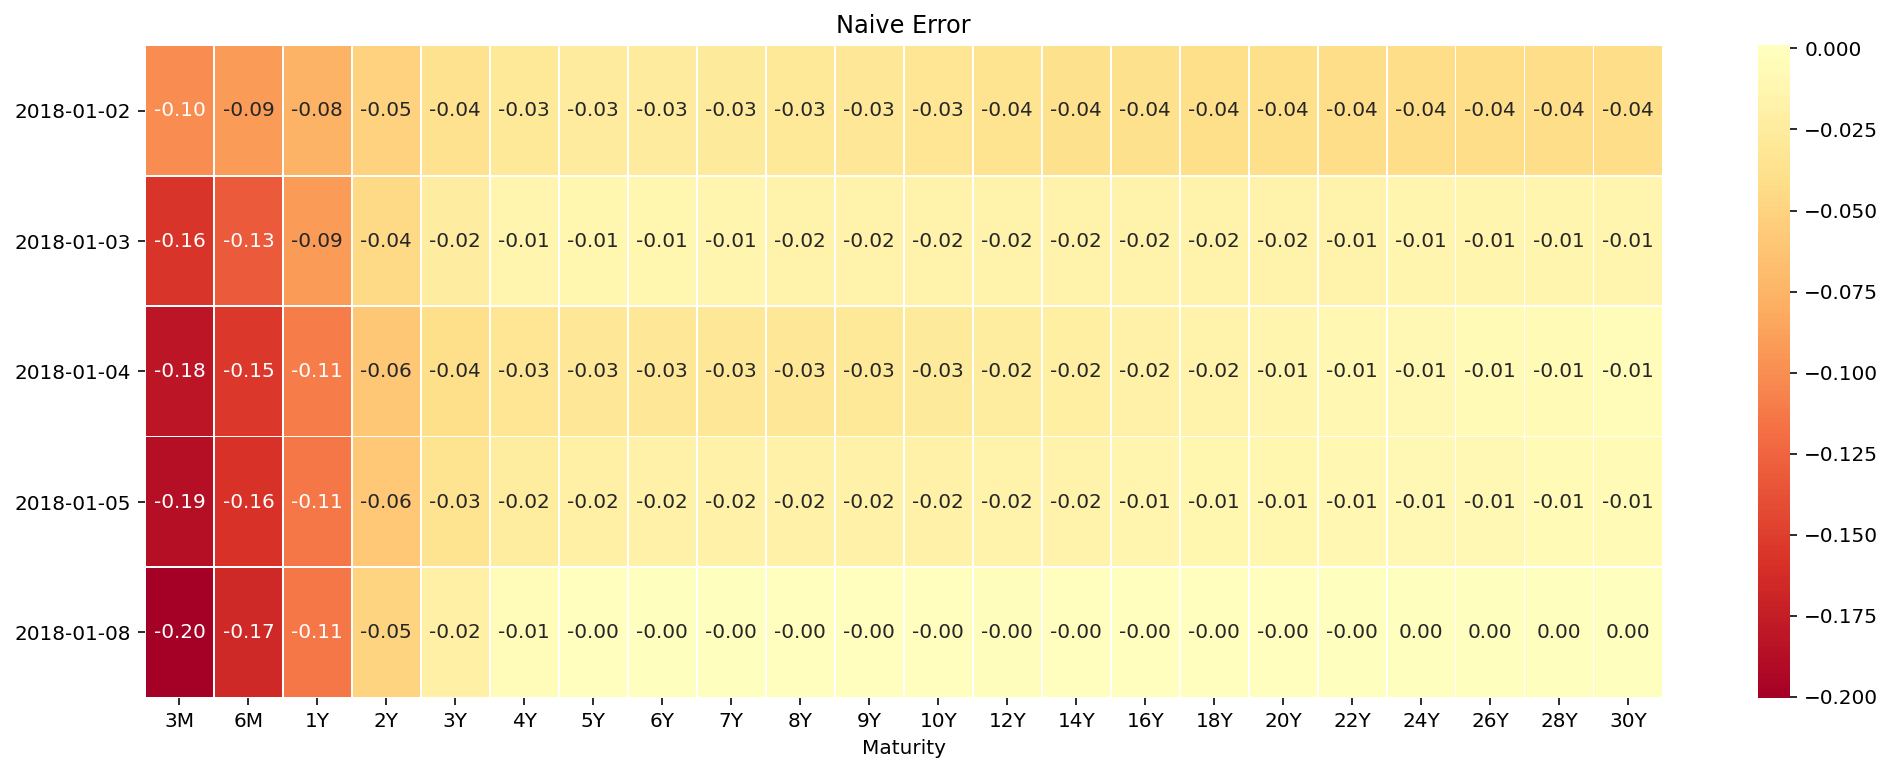

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (17,6))

plt.title("Naive Error", fontsize = 12)
ttl = ax.title
ttl.set_position([0.5,1.02])

sns.heatmap(error_naive, 
            fmt=".2f", 
            cmap = "RdYlGn", 
            linewidth = 0.3, 
            annot = True,
            center = 0)

plt.yticks(rotation=0)
plt.xlabel("Maturity")
plt.show()

### 9 Visualization
***

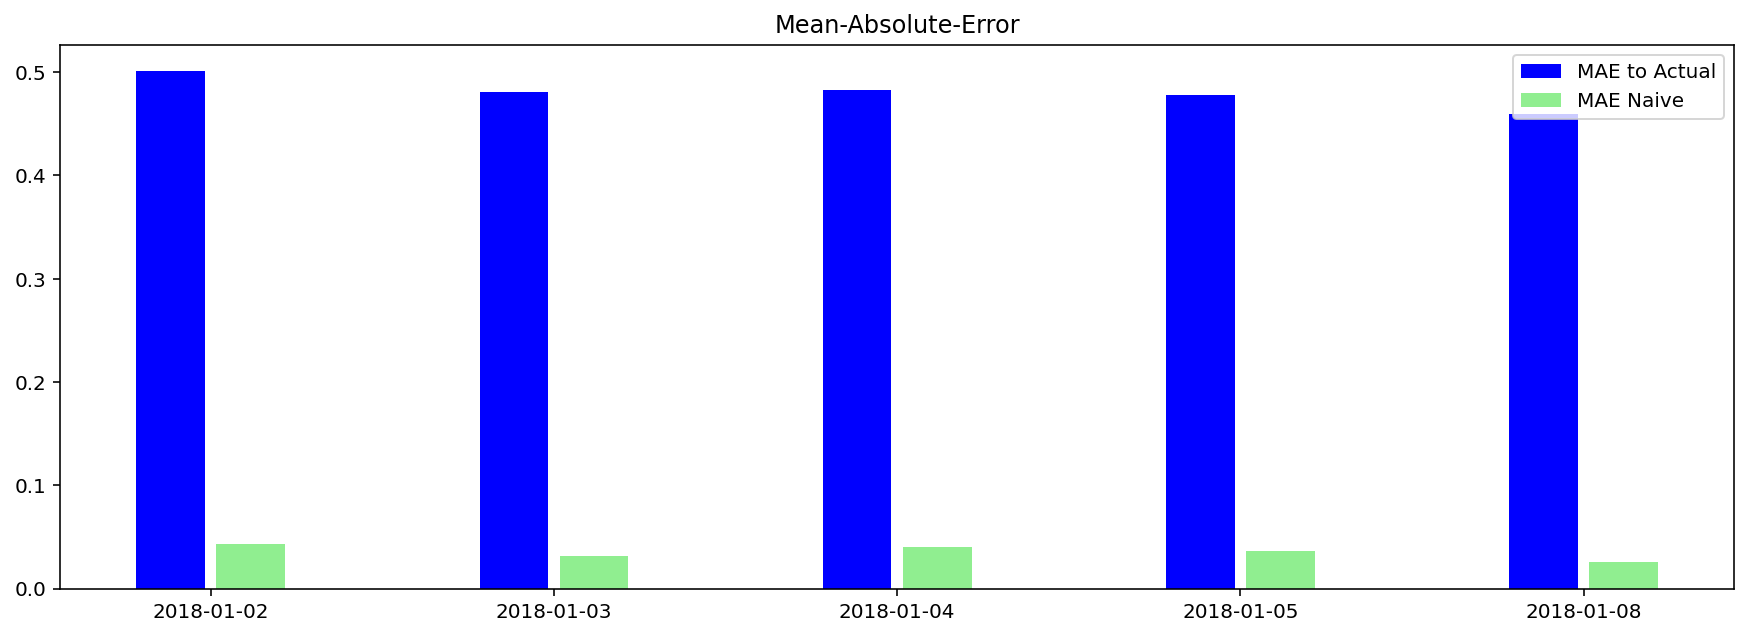

In [34]:
# Helper variables ----------------------------------------------------------
indx = np.arange(err.shape[0])
bar_width = 0.2


# Chart ---------------------------------------------------------------------
fig, ax = plt.subplots(1,1, figsize = [15,5])

ax.bar(indx - 0.05 - bar_width/3, err["mae_act"], bar_width, color = "blue", label = "MAE to Actual")
ax.bar(indx + 0.05 + bar_width/3, err["mae_naive"], bar_width, color = "lightgreen", label = "MAE Naive")

ax.set_title("Mean-Absolute-Error")
ax.set_xticks(indx)
ax.set_xticklabels(err.index.date)
ax.legend()

plt.show()

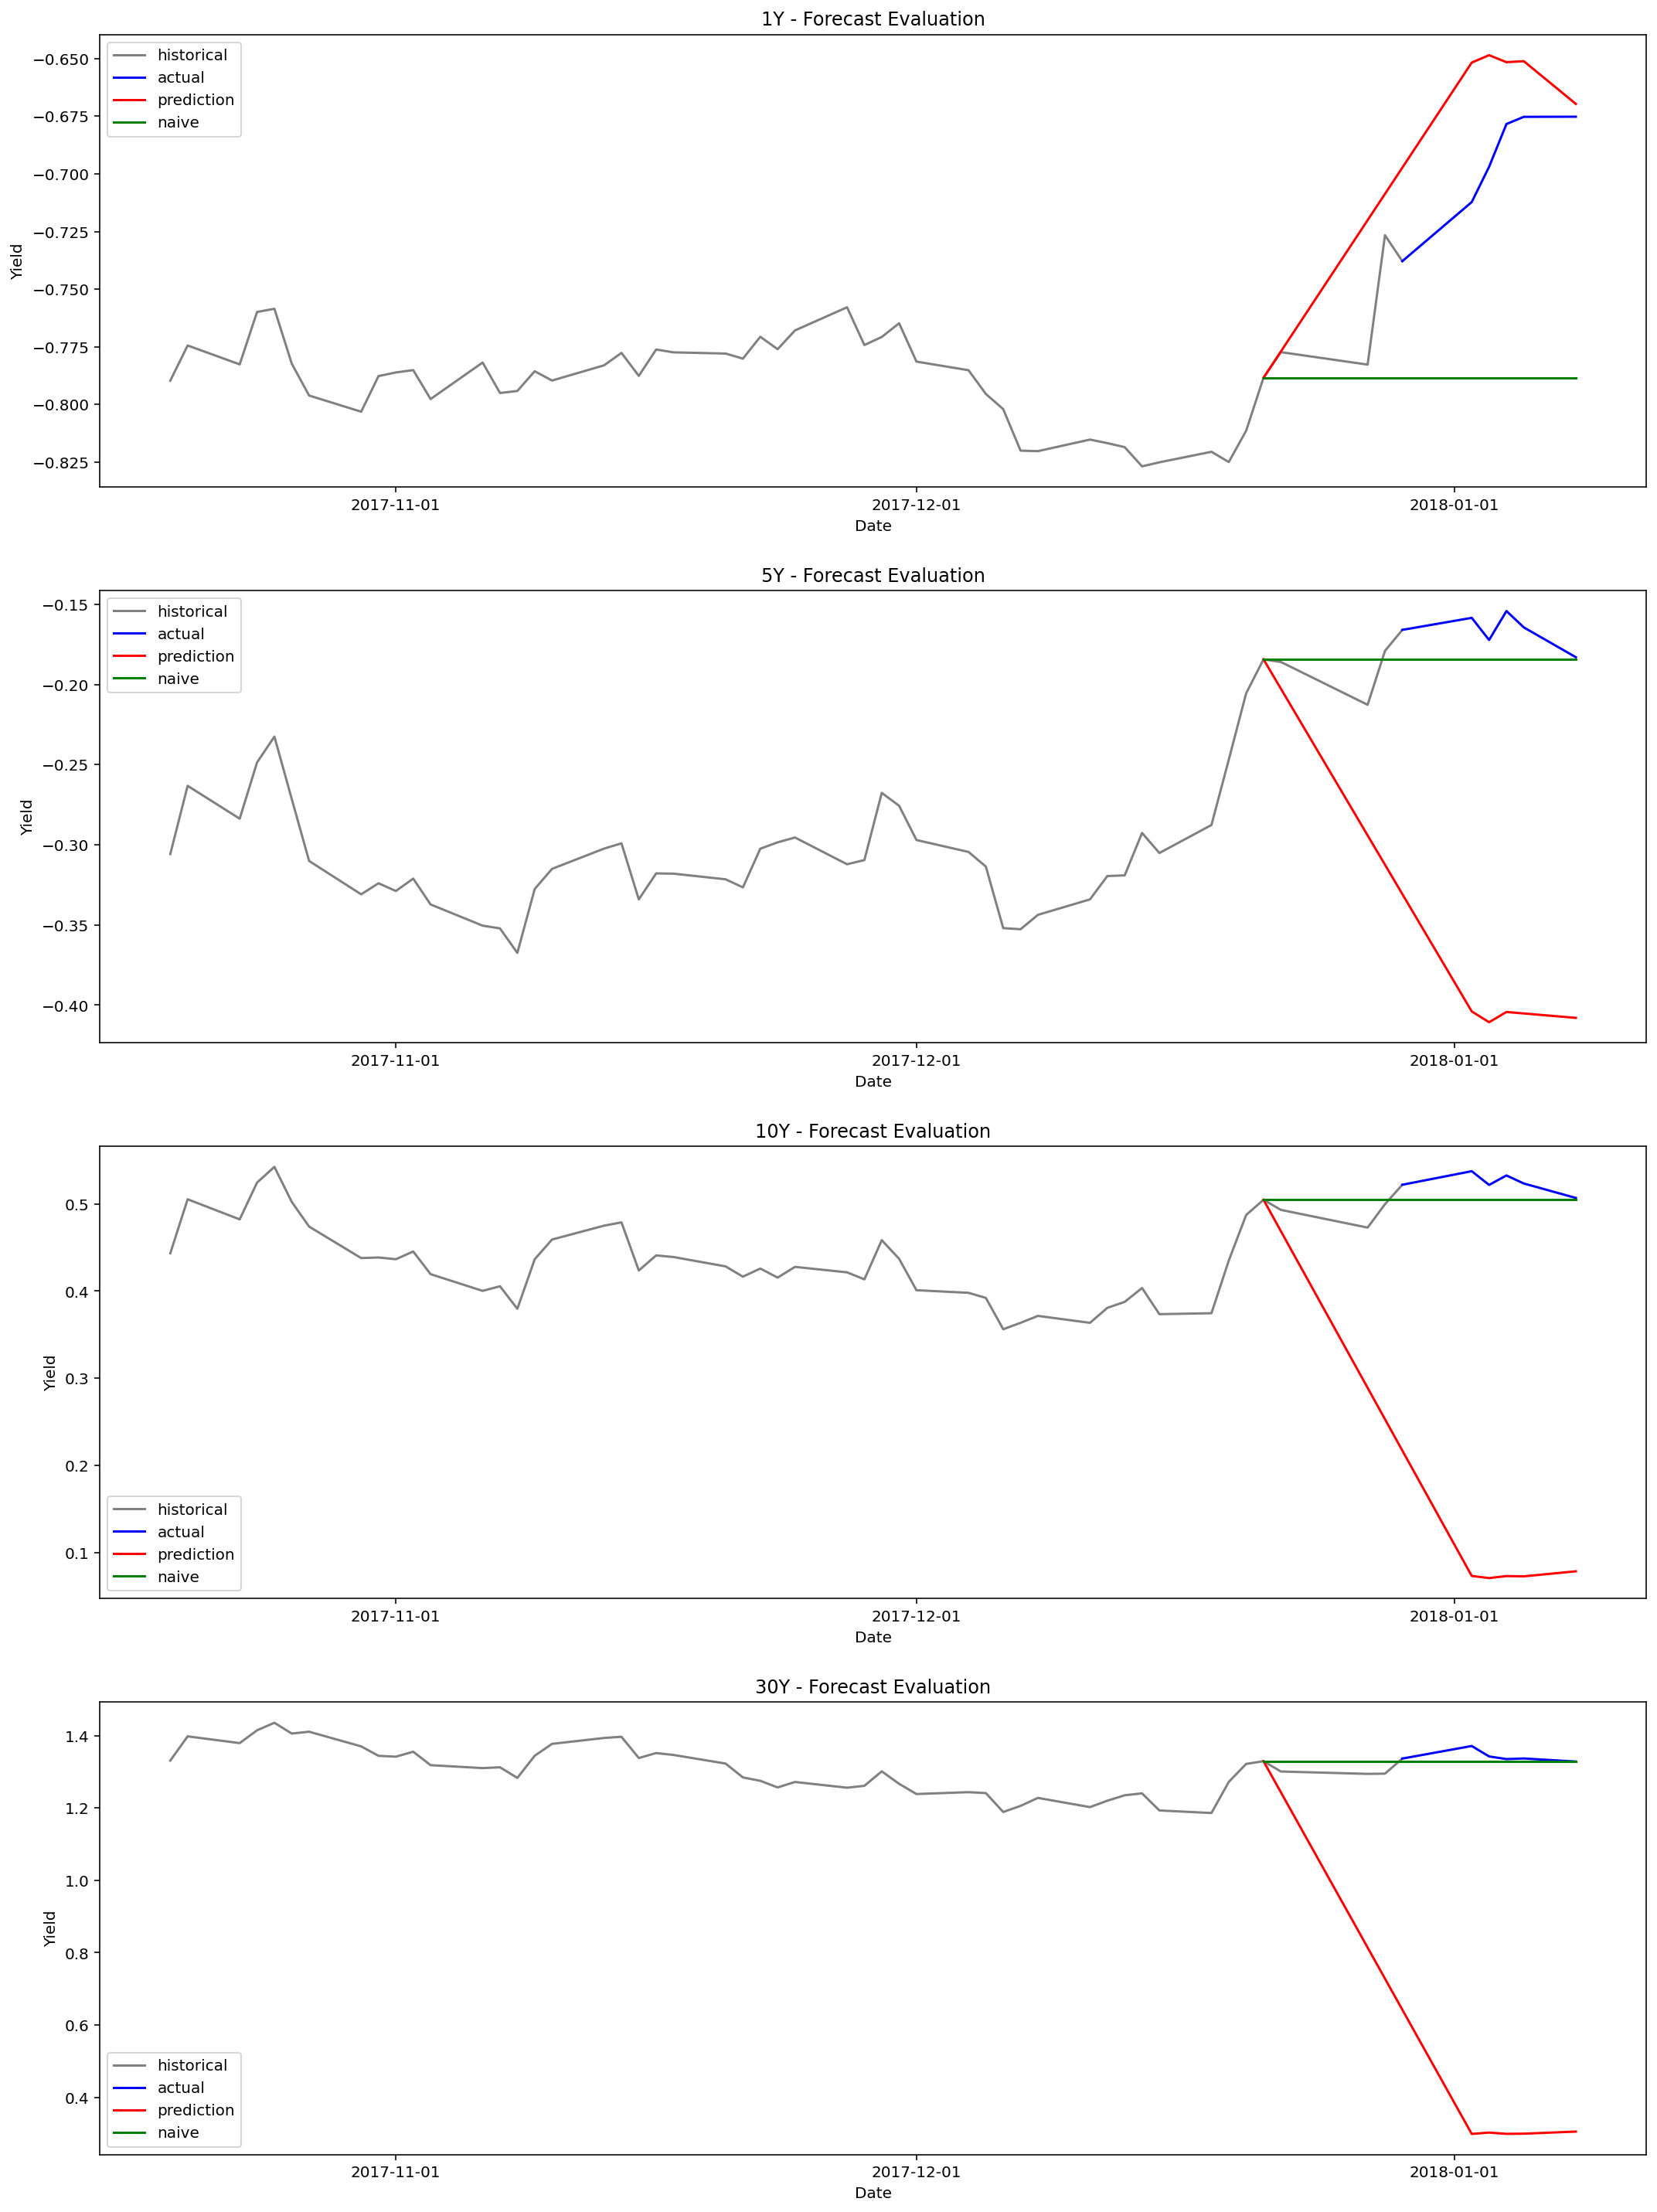

In [35]:
# Visual settings ---------------------------------------------------------
maturities = ["1Y","5Y","10Y","30Y"]
days_hist = 50

fig, ax = plt.subplots(len(maturities), 1, figsize = (15,5*len(maturities)))

# Data for chart ----------------------------------------------------------
chart_hist = spot_train.iloc[-days_hist:,:]
chart_act  = pd.concat([spot_train.iloc[-1:],spot_test.iloc[:steps]], axis = 0)
chart_naive = pd.concat([spot_train.iloc[-steps:-steps+1],naive], axis = 0)
chart_pred = pd.concat([spot_train.iloc[-steps:-steps+1],pred_spot], axis = 0)

# Chart -------------------------------------------------------------------
for i,j in enumerate(maturities):
    ax[i].plot (chart_hist[j], c="grey", label = "historical")
    ax[i].plot (chart_act[j], c="blue", label = "actual")
    ax[i].plot (chart_pred[j], c="red", label = "prediction")
    ax[i].plot (chart_naive[j], c="green", label = "naive")

    ax[i].set_title (j+" - Forecast Evaluation")
    ax[i].set_xlabel ("Date")
    ax[i].set_ylabel ("Yield")

    ax[i].xaxis.set_major_formatter(days_fmt)
    ax[i].xaxis.set_major_locator(months)
    ax[i].legend()


plt.tight_layout(h_pad=2.0)
plt.show()